<a href="https://colab.research.google.com/github/TeamMAMI/MAMI/blob/captions/KerasCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

based on a tutorial here \
https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/

In [11]:
# Install Kaggle
# %cd ~/.kaggle
# %cp ../../content/drive/MyDrive/kaggle.json ./
# %cp ~/content/drive/MyDrive/kaggle.json kaggle.json
# !ls

In [12]:
# Load Flickr 8k dataset
# %mkdir flickr8k
# %cd ../../content/drive/MyDrive/TeamMAMI
# %cd flickr8k
# !kaggle datasets download adityajn105/flickr8k
# !unzip "flickr8k.zip" -d "./flickr8k_dataset/"
# !ls flickr8k_dataset

In [31]:
# imports to make files for trial, test texts
import random
import pandas as pd
from pandas import read_csv

In [14]:
# make lists for training and testing
# df = pd.DataFrame(data=read_csv('captions.txt'))
# print(df)

# image_list = list(set(df["image"].tolist()))
# print(image_list)
# print(len(image_list))

# random.shuffle(image_list)
# print(len(image_list))

# train_images = image_list[:6000]
# test_images = image_list[6000:]

# print(len(train_images))
# print(len(test_images))

In [15]:
# make text files from the lists
# %mkdir Text
# %cd Text

# textfile = open("flickr8k_train_images.txt", "w")
# for element in train_images:
  # textfile.write(element + "\n")
# textfile.close()

# textfile = open("flickr8k_test_images.txt", "w")
# for element in test_images:
  # textfile.write(element + "\n")
# textfile.close()

In [16]:
# back to the parent directory
# %cd ..
# !ls

In [17]:
# !kaggle datasets download anindya2906/glove6b
# %mkdir Glove6b
# !unzip "glove6b.zip" -d "./Glove6b/"

In [18]:
%cd drive/Shareddrives/team_MAMI/flickr8k/flickr8k_dataset
!ls

/content/drive/Shareddrives/team_MAMI/flickr8k/flickr8k_dataset
Glove6b  glove6b.zip  Images  Text


In [19]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizer_v2 import adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils.np_utils import to_categorical

In [20]:
token_path = "Text/captions.txt"
train_images_path = "Text/flickr8k_train_images.txt"
test_images_path = "Text/flickr8k_test_images.txt"
images_path = "Images/"
glove_path = 'Glove6b/'

doc = open(token_path,'r').read()
print(doc[:410])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cab


In [21]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [22]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

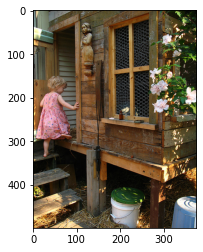

['child in a pink dress is climbing up a set of stairs in an entry way ',
 'girl going into a wooden building ',
 'little girl climbing into a wooden playhouse ',
 'little girl climbing the stairs to her playhouse ',
 'little girl in a pink dress going into a wooden cabin ']

In [23]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [24]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8745


In [25]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [26]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [27]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [89]:
print(test_img)

['Images/374103966_2987706be1.jpg', 'Images/405537503_f66ecc5073.jpg', 'Images/3760400645_3ba51d27f9.jpg', 'Images/403523132_73b9a1a4b3.jpg', 'Images/405970010_8cebaa77d3.jpg', 'Images/393810324_1c33760a95.jpg', 'Images/3726590391_bc6e729bb6.jpg', 'Images/3726168984_1fa2c8965b.jpg', 'Images/380537190_11d6c0a412.jpg', 'Images/374103776_0de490c1b0.jpg', 'Images/396179143_e1511336e1.jpg', 'Images/3737539561_d1dc161040.jpg', 'Images/3726120436_740bda8416.jpg', 'Images/405051459_3b3a3ba5b3.jpg', 'Images/380041023_0dfd712ef1.jpg', 'Images/386470686_1ae9242878.jpg', 'Images/3747543364_bf5b548527.jpg', 'Images/401079494_562454c4d6.jpg', 'Images/397725001_e51f7c391c.jpg', 'Images/380590140_25b9889772.jpg', 'Images/381052465_722e00807b.jpg', 'Images/404890608_33f138aefa.jpg', 'Images/384577800_fc325af410.jpg', 'Images/3728164558_52729baefa.jpg', 'Images/390992388_d74daee638.jpg', 'Images/444481722_690d0cadcf.jpg', 'Images/433855742_c2a6fda763.jpg', 'Images/437917001_ae1106f34e.jpg', 'Images/4390

In [28]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [57]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [58]:
print(all_train_captions)

['startseq child in a pink dress is climbing up a set of stairs in an entry way endseq', 'startseq girl going into a wooden building endseq', 'startseq little girl climbing into a wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in a pink dress going into a wooden cabin endseq', 'startseq man lays on a bench while his dog sits by him endseq', 'startseq man lays on the bench to which a white dog is also tied endseq', 'startseq man sleeping on a bench outside with a white and black dog sitting next to him endseq', 'startseq shirtless man lies on a park bench with his dog endseq', 'startseq laying on bench holding leash of dog sitting on ground endseq', 'startseq man in an orange hat starring at something endseq', 'startseq man wears an orange hat and glasses endseq', 'startseq man with gauges and glasses is wearing a blitz hat endseq', 'startseq man with glasses is wearing a beer can crocheted hat endseq', 'startseq man w

In [59]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
print(word_counts['startseq'])
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1650


In [61]:
print('startseq' in vocab)

True


In [62]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [63]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 34


In [64]:
glove_path = 'Glove6b/'
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [65]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [66]:
model = InceptionV3(weights='imagenet')

In [67]:
model_new = Model(model.input, model.layers[-2].output)

In [42]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [43]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

In [88]:
print(encoding_test)

{'374103966_2987706be1.jpg': array([0.6279228 , 0.5520586 , 0.4783979 , ..., 0.10421912, 0.4194729 ,
       0.18079749], dtype=float32), '405537503_f66ecc5073.jpg': array([2.4890602e-02, 1.4385560e-01, 1.7418659e-03, ..., 5.0273217e-02,
       4.5847610e-01, 1.7566248e+00], dtype=float32), '3760400645_3ba51d27f9.jpg': array([0.36690682, 0.98870087, 1.3196869 , ..., 0.58398503, 0.67457336,
       0.06180508], dtype=float32), '403523132_73b9a1a4b3.jpg': array([0.26288256, 0.22137809, 0.09339648, ..., 0.44959542, 0.30000508,
       0.19220679], dtype=float32), '405970010_8cebaa77d3.jpg': array([0.11360437, 0.18768649, 0.5758143 , ..., 0.8150203 , 0.67250925,
       0.40282226], dtype=float32), '393810324_1c33760a95.jpg': array([0.10473733, 0.06795701, 0.31998459, ..., 0.14847012, 0.70565003,
       0.30122823], dtype=float32), '3726590391_bc6e729bb6.jpg': array([0.6405828 , 0.29835993, 0.70352066, ..., 0.15478325, 0.5989161 ,
       0.50125396], dtype=float32), '3726168984_1fa2c8965b.jpg'

In [68]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 200)      330200      ['input_6[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_5[0][0]']                
                                                                                            

In [69]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [70]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [71]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [73]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
2000/2000 [==============================] - 172s 86ms/step - loss: 3.7485
Epoch 2/30
2000/2000 [==============================] - 170s 85ms/step - loss: 3.2087
Epoch 3/30
2000/2000 [==============================] - 170s 85ms/step - loss: 3.0153
Epoch 4/30
2000/2000 [==============================] - 170s 85ms/step - loss: 2.8956
Epoch 5/30
2000/2000 [==============================] - 170s 85ms/step - loss: 2.8092
Epoch 6/30
2000/2000 [==============================] - 169s 84ms/step - loss: 2.7446
Epoch 7/30
2000/2000 [==============================] - 169s 85ms/step - loss: 2.6886
Epoch 8/30
2000/2000 [==============================] - 170s 85ms/step - loss: 2.6457
Epoch 9/30
2000/2000 [==============================] - 170s 85ms/step - loss: 2.6071
Epoch 10/30
2000/2000 [==============================] - 170s 85ms/step - loss: 2.5749
Epoch 11/30
2000/2000 [==============================] - 170s 85ms/step - loss: 2.5475
Epoch 12/30
2000/2000 [=============================

In [75]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [76]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

#Test a couple from the test set

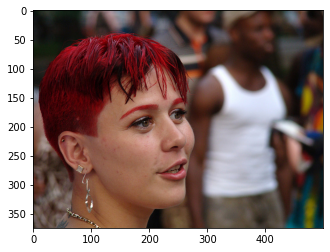

Greedy Search: young girl in a pink dress is blowing a whistle
Beam Search, K = 3: young girl in a pink dress is standing in front of a tree
Beam Search, K = 5: young girl in a pink dress has her mouth open as she walks down the street
Beam Search, K = 7: little girl in a pink dress is holding a plastic cup in her hand
Beam Search, K = 10: group of teenagers smiling for the camera


In [77]:
pic = '2895700779_fac1d9d278.jpg'
test_image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(test_image))
print("Beam Search, K = 3:",beam_search_predictions(test_image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(test_image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(test_image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(test_image, beam_index = 10))

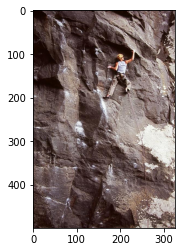

Greedy: man is climbing a mountain
Beam Search, K = 3: man climbing a mountain
Beam Search, K = 5: man climbing a mountain
Beam Search, K = 7: man climbing a mountain


In [78]:
pic = list(encoding_test.keys())[1]
test_image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(test_image))
print("Beam Search, K = 3:",beam_search_predictions(test_image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(test_image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(test_image, beam_index = 7))

#Prepare the MAMI cleaned images for captioning

In [82]:
cleaned_pngs_path = "../../MAMI/strippedImage/"
cleaned_images_path = "Text/mami_clean_images.txt"

make a list of all the cleaned image file names

In [81]:
!ls

Glove6b  glove6b.zip  Images  Text


In [83]:
clean = []

for filename in os.listdir(cleaned_pngs_path):
    if filename.endswith("png"): 
        clean.append(filename)

print(clean)


['image_0.png', 'image_1.png', 'image_2.png', 'image_3.png', 'image_4.png', 'image_5.png', 'image_6.png', 'image_7.png', 'image_8.png', 'image_9.png', 'image_10.png', 'image_11.png', 'image_12.png', 'image_13.png', 'image_14.png', 'image_15.png', 'image_16.png', 'image_17.png', 'image_18.png', 'image_19.png', 'image_20.png', 'image_21.png', 'image_22.png', 'image_23.png', 'image_24.png', 'image_25.png', 'image_26.png', 'image_27.png', 'image_28.png', 'image_29.png', 'image_30.png', 'image_31.png', 'image_32.png', 'image_33.png', 'image_34.png', 'image_35.png', 'image_36.png', 'image_37.png', 'image_38.png', 'image_39.png', 'image_40.png', 'image_41.png', 'image_42.png', 'image_43.png', 'image_44.png', 'image_45.png', 'image_46.png', 'image_47.png', 'image_48.png', 'image_49.png', 'image_50.png', 'image_51.png', 'image_52.png', 'image_53.png', 'image_54.png', 'image_55.png', 'image_56.png', 'image_57.png', 'image_58.png', 'image_59.png', 'image_60.png', 'image_61.png', 'image_62.png', '

make a text file from the cleaned image list

In [84]:
%cd Text
!ls

textfile = open("mami_clean_images.txt", "w")
for element in clean:
  textfile.write(element + "\n")
textfile.close()

%cd ..
!ls

/content/drive/Shareddrives/team_MAMI/flickr8k/flickr8k_dataset/Text
captions.txt  flickr8k_test_images.txt	flickr8k_train_images.txt
/content/drive/Shareddrives/team_MAMI/flickr8k/flickr8k_dataset
Glove6b  glove6b.zip  Images  Text


make a list of cleaned images

In [105]:
cl_img = glob.glob(cleaned_pngs_path + '*.png')

clean_images = set(open(cleaned_images_path, 'r').read().strip().split('\n'))
clean_img = []
for i in cl_img:
  if i[len(cleaned_pngs_path):] in clean: 
    clean_img.append(i)

In [106]:
print(sorted(clean_img))
print(len(clean_img))
print(cl_img)

['../../MAMI/strippedImage/image_0.png', '../../MAMI/strippedImage/image_1.png', '../../MAMI/strippedImage/image_10.png', '../../MAMI/strippedImage/image_11.png', '../../MAMI/strippedImage/image_12.png', '../../MAMI/strippedImage/image_13.png', '../../MAMI/strippedImage/image_14.png', '../../MAMI/strippedImage/image_15.png', '../../MAMI/strippedImage/image_16.png', '../../MAMI/strippedImage/image_17.png', '../../MAMI/strippedImage/image_18.png', '../../MAMI/strippedImage/image_19.png', '../../MAMI/strippedImage/image_2.png', '../../MAMI/strippedImage/image_20.png', '../../MAMI/strippedImage/image_21.png', '../../MAMI/strippedImage/image_22.png', '../../MAMI/strippedImage/image_23.png', '../../MAMI/strippedImage/image_24.png', '../../MAMI/strippedImage/image_25.png', '../../MAMI/strippedImage/image_26.png', '../../MAMI/strippedImage/image_27.png', '../../MAMI/strippedImage/image_28.png', '../../MAMI/strippedImage/image_29.png', '../../MAMI/strippedImage/image_3.png', '../../MAMI/strippe

encode the cleaned images

In [108]:
from keras.preprocessing import image
encoding_clean = {}
for img in clean_img:
    encoding_clean[img[len(cleaned_pngs_path):]] = encode(img)

try an image from our cleaned dataset

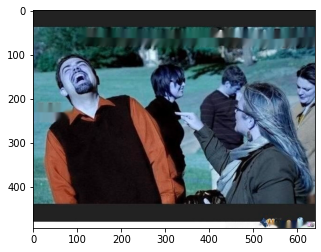

Greedy Search: man in a red jacket is eating a paper
Beam Search, K = 3: group of people are sitting on a bus in front of a bus
Beam Search, K = 5: group of people are gathered in front of some houses
Beam Search, K = 7: group of people are gathered in front of some houses
Beam Search, K = 10: group of people in hard clothing stand in front of a white building


In [109]:
pic = 'image_20.png'
image = encoding_clean[pic].reshape((1,2048))
x=plt.imread(cleaned_pngs_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

do all the cleaned images

In [110]:
textfile = open("clean_image_captions.csv", "w")

for pic in clean_images:
  image = encoding_clean[pic].reshape((1,2048))
  textfile.write(pic + ", " + greedySearch(image) + "\n")
  textfile.write(pic + ", " + beam_search_predictions(image, beam_index = 3) + "\n")
  textfile.write(pic + ", " + beam_search_predictions(image, beam_index = 5) + "\n")
  textfile.write(pic + ", " + beam_search_predictions(image, beam_index = 7) + "\n")
  textfile.write(pic + ", " + beam_search_predictions(image, beam_index = 10) + "\n")

textfile.close()